Training for n = 0...
Epoch 0, Loss: 2.766012191772461
Epoch 1000, Loss: 1.72197451320244e-05
Epoch 2000, Loss: 1.2625693670997862e-05
Epoch 3000, Loss: 1.5110670574358664e-05
Epoch 4000, Loss: 1.5409190382342786e-05
Epoch 5000, Loss: 3.128147727693431e-05
Epoch 6000, Loss: 2.32929323829012e-05
Epoch 7000, Loss: 1.1617580639722291e-05
Epoch 8000, Loss: 2.763866723398678e-05
Epoch 9000, Loss: 0.00015944280312396586


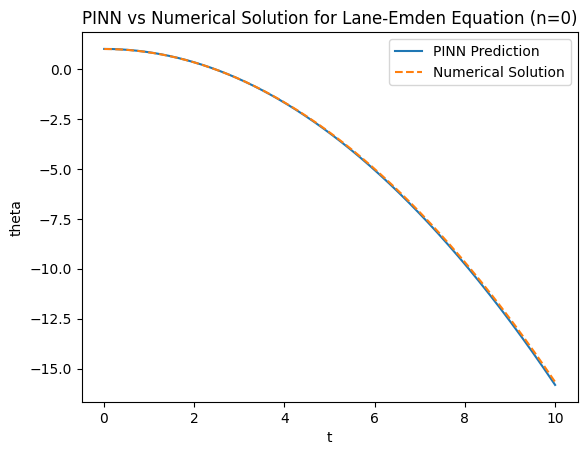

Training for n = 1...
Epoch 0, Loss: 2.8513004779815674
Epoch 1000, Loss: 0.0018902247538790107
Epoch 2000, Loss: 0.0003650834260042757
Epoch 3000, Loss: 0.0001169979150290601
Epoch 4000, Loss: 9.40985992201604e-05
Epoch 5000, Loss: 3.981253757956438e-05
Epoch 6000, Loss: 2.4605302314739674e-05
Epoch 7000, Loss: 1.7980590200750157e-05
Epoch 8000, Loss: 1.7150641724583693e-05
Epoch 9000, Loss: 1.8769665985018946e-05


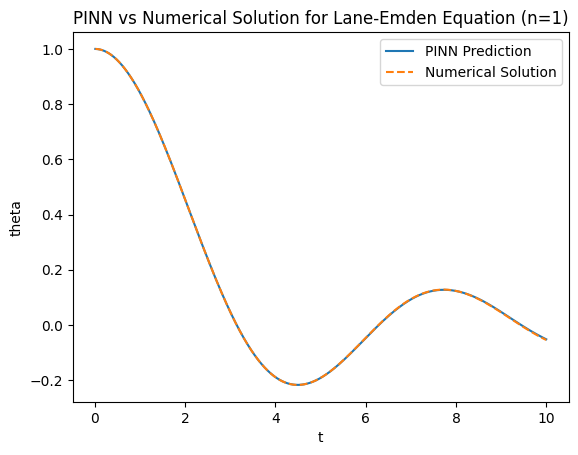

Training for n = 2...
Epoch 0, Loss: 0.8605733513832092
Epoch 1000, Loss: 0.0004341938765719533
Epoch 2000, Loss: 0.0002588167553767562
Epoch 3000, Loss: 0.0002767618279904127
Epoch 4000, Loss: 0.0002437324437778443
Epoch 5000, Loss: 0.0006533270934596658
Epoch 6000, Loss: 0.00022616244677919894
Epoch 7000, Loss: 0.00022795249242335558
Epoch 8000, Loss: 0.00021295459009706974
Epoch 9000, Loss: 0.00020538231183309108


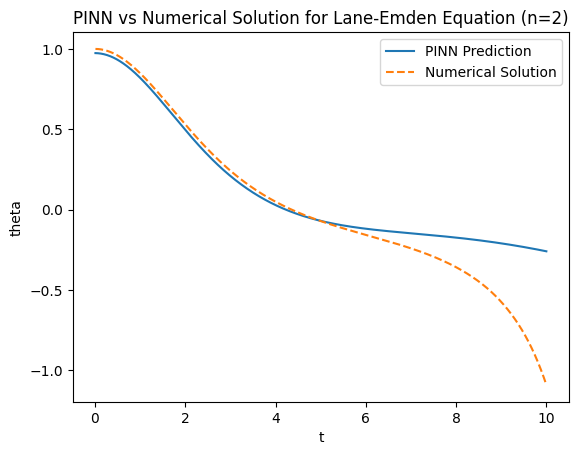

Training for n = 3...
Epoch 0, Loss: 0.4334414005279541
Epoch 1000, Loss: 1.7203510651597753e-05
Epoch 2000, Loss: 2.363536987104453e-05
Epoch 3000, Loss: 1.5283379980246536e-05
Epoch 4000, Loss: 2.1061336155980825e-05
Epoch 5000, Loss: 1.8441141946823336e-05
Epoch 6000, Loss: 1.4013329746376257e-05
Epoch 7000, Loss: 3.860806828015484e-05
Epoch 8000, Loss: 2.6818855985766277e-05
Epoch 9000, Loss: 1.4552875654771924e-05


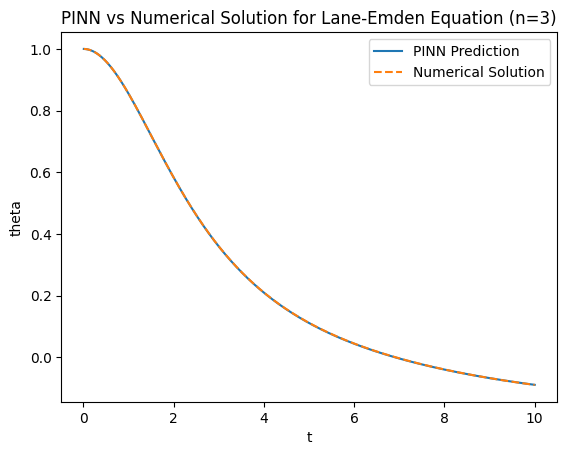

Training for n = 4...
Epoch 0, Loss: 0.4282354712486267
Epoch 1000, Loss: 1.8385988369118422e-05
Epoch 2000, Loss: 1.1402685231587384e-05
Epoch 3000, Loss: 0.0005221592145971954
Epoch 4000, Loss: 1.2973840057384223e-05
Epoch 5000, Loss: 7.154342165449634e-05
Epoch 6000, Loss: 1.5327845176216215e-05
Epoch 7000, Loss: 1.1828786227852106e-05
Epoch 8000, Loss: 1.1579585589061026e-05
Epoch 9000, Loss: 1.2917205822304823e-05


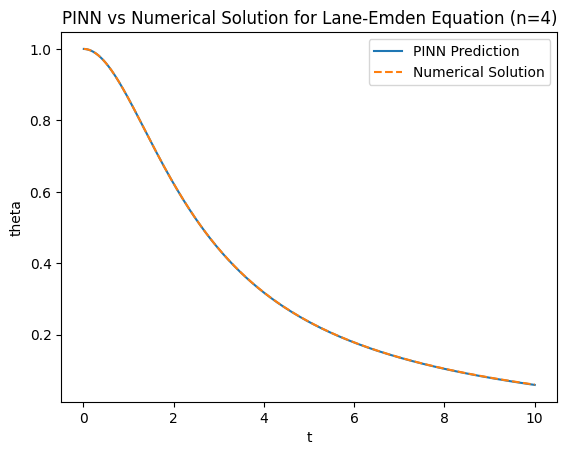

Training for n = 5...
Epoch 0, Loss: 1.414350152015686
Epoch 1000, Loss: 0.0006937746657058597
Epoch 2000, Loss: 1.190913280879613e-05
Epoch 3000, Loss: 1.2439967576938216e-05
Epoch 4000, Loss: 1.570676249684766e-05
Epoch 5000, Loss: 3.0002236599102616e-05
Epoch 6000, Loss: 1.2099438208679203e-05
Epoch 7000, Loss: 4.825226642424241e-05
Epoch 8000, Loss: 2.1175310394028202e-05
Epoch 9000, Loss: 1.352776507701492e-05


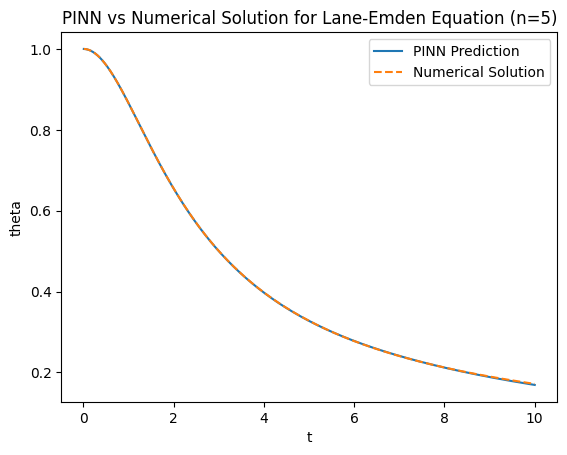

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 1)
        self.activation = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, t):
        x = self.activation(self.fc1(t))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.softplus(self.fc4(x))
        x = self.fc5(x)
        return x

# Define the Lane-Emden residual
def lane_emden_residual(model, t, n):
    t.requires_grad_(True)
    theta = model(t)
    dtheta_dt = torch.autograd.grad(theta, t, grad_outputs=torch.ones_like(theta), create_graph=True)[0]
    d2theta_dt2 = torch.autograd.grad(dtheta_dt, t, grad_outputs=torch.ones_like(dtheta_dt), create_graph=True)[0]
    residual = d2theta_dt2 + (2/t) * dtheta_dt + torch.pow(theta, n)
    return residual

# Define the loss function including boundary conditions
def loss(model, t, t_boundary, theta_boundary, dtheta_dt_boundary, n):
    residual = lane_emden_residual(model, t, n)

    # Set requires_grad=True for t_boundary to calculate gradient at boundary
    t_boundary.requires_grad_(True)

    boundary_loss = torch.mean((model(t_boundary) - theta_boundary) ** 2) + \
                    torch.mean((torch.autograd.grad(model(t_boundary), t_boundary, grad_outputs=torch.ones_like(t_boundary), create_graph=True)[0] - dtheta_dt_boundary) ** 2)
    return torch.mean(residual ** 2) + boundary_loss

# Training step
def train_step(model, t, t_boundary, theta_boundary, dtheta_dt_boundary, optimizer, n):
    optimizer.zero_grad()
    loss_value = loss(model, t, t_boundary, theta_boundary, dtheta_dt_boundary, n)
    loss_value.backward()
    optimizer.step()
    return loss_value

# Generate training data
def generate_training_data(num_points):
    t = np.linspace(0.01, 10, num_points).reshape(-1, 1)
    return t

# Solve the Lane-Emden equation using a numerical method
def solve_lane_emden_numerically(n, t_max, num_points):
    def lane_emden_rhs(t, y, n):
        theta, theta_prime = y
        return [theta_prime, -2/t * theta_prime - theta**n]

    t_eval = np.linspace(0.01, t_max, num_points)
    sol = solve_ivp(lane_emden_rhs, [0.01, t_max], [1, 0], args=(n,), t_eval=t_eval)
    return sol.t, sol.y[0]

# Training function for multiple Lane-Emden cases
def train_and_evaluate_for_n_values(n_values, num_points=1000, epochs=10000, lr=0.001):
    results = {}

    for n in n_values:
        print(f"Training for n = {n}...")

        # Generate training data
        t = generate_training_data(num_points)
        t = torch.tensor(t, dtype=torch.float32)

        # Boundary conditions
        t_boundary = torch.tensor([[0.01]], dtype=torch.float32, requires_grad=True)
        theta_boundary = torch.tensor([[1.0]], dtype=torch.float32)
        dtheta_dt_boundary = torch.tensor([[0.0]], dtype=torch.float32)

        # Initialize the model and optimizer
        model = PINN()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop
        for epoch in range(epochs):
            loss_value = train_step(model, t, t_boundary, theta_boundary, dtheta_dt_boundary, optimizer, n)
            if epoch % 1000 == 0:
                print(f'Epoch {epoch}, Loss: {loss_value.item()}')

        # Predict with the PINN model
        t_test = np.linspace(0.01, 10, num_points).reshape(-1, 1)
        t_test_tensor = torch.tensor(t_test, dtype=torch.float32)
        theta_pred = model(t_test_tensor).detach().numpy()

        # Solve the equation numerically
        t_num, theta_num = solve_lane_emden_numerically(n, t_max=10, num_points=num_points)

        # Store results
        results[n] = {
            't_test': t_test,
            'theta_pred': theta_pred,
            't_num': t_num,
            'theta_num': theta_num
        }

        # Plot the results
        plt.figure()
        plt.plot(t_test, theta_pred, label='PINN Prediction')
        plt.plot(t_num, theta_num, label='Numerical Solution', linestyle='dashed')
        plt.xlabel('t')
        plt.ylabel('theta')
        plt.legend()
        plt.title(f'PINN vs Numerical Solution for Lane-Emden Equation (n={n})')
        plt.show()

    return results

if __name__ == "__main__":
    # List of n values for Lane-Emden equations
    n_values = [0, 1, 2, 3, 4, 5]

    # Train and evaluate the model for each n value
    results = train_and_evaluate_for_n_values(n_values)